## Tarea 3,  parte 1: GAIA!

**1- Sobre GAIA** 

GAIA es una sonda espacial lanzada en Diciembre de 2013. Se encuentra en la orbita L2, a 1.5 millones de kilometros de la Tierra. Su misión principal es realizar un mapeo tridimensional de la Via Lactea para poder profundizar en su composición, formación y evolución. Durante su misión se espera que GAIA logre observar alrededor del 1% de toda la población estelar de la galaxia, además de otros cuerpos celestes como exoplanetas y asteriodes.  

El mapeo tridimensional considera mediciones astrométricas y brillo fotométricas, por ejemplo, las posiciones, el movimiento y el brillo superficial de las estrellas. Además, se espera que GAIA logre observar al menos 70 veces cada una de las fuentes, esto junto con las mejoras técnicas con las que no contaba su predecesor, Hipparcos, permitirían obtener mediciones muy precisas de la cinemática y del brillo superficial. 

El 14 de Septiembre GAIA se publicaron los primeros datos recopilados durante sus primeros años de operación. Estre los datos se incluyen las posiciones y magnitudes de 1100 millones de estrellas donde los movimientos propios de más de 2 millones de ellas se encuentran en el Tycho-Gaia-Astrometric Solution (TGAS). 

**2- Sobre el catálogo RAVE-ON**

RAVE es un survey de espectrografía cuyo principal objetivo es medir las velocidades radiales de 10^6 estrellas además de parámetros estelares y composiciones químicas. Debido a que se debe analizar un gran número de estrellas el tiempo de exposición es muy limitado lo que algunas veces implica mediciones con poca señal a ruido (S/N).

Debido a que la primera liberación de datos de GAIA no contará con parámetros estelares ni con velocidades radiales se realiza un match entre el catálogo RAVE y los objetos de GAIA. El match permite una descripción completa de más de 250000 estrellas.

In [2]:
import numpy as np
import time
import fitsio
from astropy.io.fits import getdata

In [3]:
import gaia_tools.load as gload
tgas_cat= gload.tgas()
raveon_cat= gload.raveon()

Para analizar la estructura de TGAS y RAVE-ON analizamos los headers de 2 imágenes.

In [5]:
tgas1, htgas1 = getdata('TgasSource_000-000-000.fits',1, header = "True")
rave_on, hrave_on = getdata('RAVE-on-v1.0.fits',1, header = "True")

En este header podemos ver que los fits de TGAS contienen una tabla binaria donde podemos encontrar datos como la ascencion recta, declinación, el paralaje y la magnitud en la banda G. Podemos observar que cada objeto tiene 59 entradas.

In [6]:
htgas1

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                  336 / width of table in bytes                        
NAXIS2  =               134865 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                   59 / number of columns                              
EXTNAME = 'TgasSource_000-000-000.fits' / table name                            
TTYPE1  = 'hip     '           / label for column 1                             
TFORM1  = 'J       '           / format for column 1                            
TNULL1  =          -2147483648 / blank value for column 1                       
TUCD1   = 'meta.id.cross'   

Y en el header de RAVE-ON podemos ver que aparecen los parámetros estelares de temperatura efectiva, gravedad superficial y metalicidad. Cada objeto tiene 58 entradas.

In [7]:
hrave_on

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  344 / length of dimension 1                          
NAXIS2  =               520701 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   58 / number of table fields                         
TTYPE1  = 'RAVE_OBS_ID'                                                         
TFORM1  = '31A     '                                                            
TTYPE2  = 'RAVEID  '                                                            
TFORM2  = '16A     '                                                            
TTYPE3  = 'RA      '        

In [8]:
# Match de los catálogos
from gaia_tools import xmatch
m1, m2, sep = xmatch.xmatch(raveon_cat, tgas_cat, colRA2='ra', colDec2='dec', 
                            epoch1=2000, epoch2=2015)    

In [9]:
par = tgas_cat[m2]['parallax']                    # Extraemos el paralaje de TGAS
par_er = tgas_cat[m2]['parallax_error']           # y su error
posval = np.where(par > 0)[0]                     # Entrega las posiciones de paralajes positivos
par, par_er = par[posval], par_er[posval]   
mask = (par / par_er) > 10.                       # Máscara de True y False. True corresponde a la condicion S/N > 10

# Extraccion de magnitudes y temperaturas
mags = (tgas_cat[m2]['phot_g_mean_mag'])[posval]  # Extraemos la magnitud relativa de TGAS
Teffs = (raveon_cat[m1]['TEFF'])[posval]          # Extraemos las temperaturas de RAVE-ON

# Conversión a magnitud absoluta
Mags = mags + 5 - 5*np.log10(1000/par)            # Conversión a magnitud absoluta (eq. 1)

# Seleccion de fuentes con S/N > 10         
Mags = Mags[mask]           
Teffs = Teffs[mask]

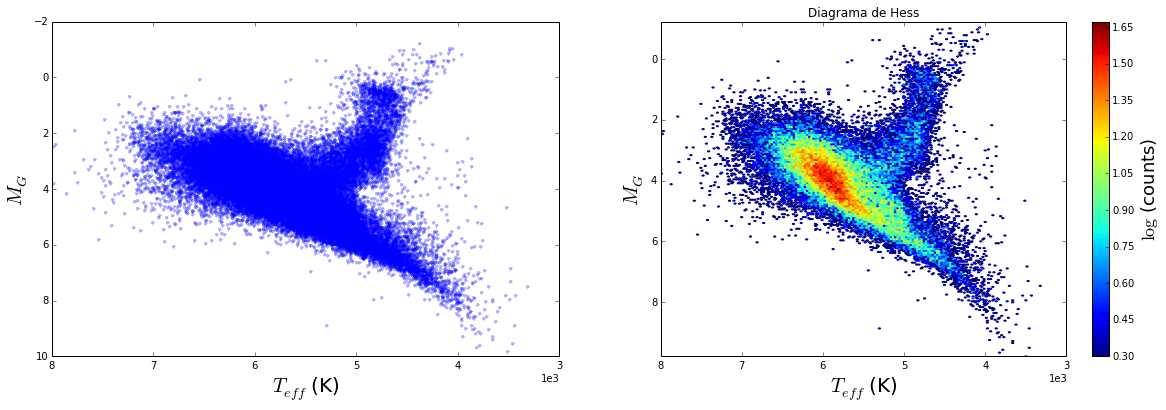

In [27]:
import matplotlib.pyplot as plt
% matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, figsize = [20,6])

ax1.plot(Teffs, Mags, 'b.', alpha = .3)
ax1.set(xlim=(8e3, 3e3), xlabel = '$T_{eff}$ (K)', ylabel = '$M_{G}$')
ax1.invert_yaxis()
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.xaxis.label.set_size(20)
ax1.yaxis.label.set_size(20)

hx = ax2.hexbin(Teffs, Mags, gridsize = 300, bins = 'log', mincnt = 1)
ax2.set(xlim=(8e3, 3e3), xlabel = '$T_{eff}$ (K)', ylabel = '$M_{G}$', title = 'Diagrama de Hess')
cb = f.colorbar(hx, ax = ax2)
cb.set_label('$\log$ (counts)', fontsize = 18)
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.xaxis.label.set_size(20)
ax2.yaxis.label.set_size(20)
ax2.invert_yaxis()

A continuación, a partir de la velocidad radial ($\rho$), el paralaje ($\pi$), el movimiento propio en ascención recta ($\mu_{\alpha}$) y el movimiento propio en declinacion ($\mu_{\delta}$) se obtendrán las velocidades físicas $V_{X}$, $V_{Y}$ y $V_{Z}$ en el eje de coordenadas galácticas rectangulares. 

Para poder relacionar ($\mu_{\delta}$), ($\mu_{\alpha}$), ($\pi$), ($\rho$) con $V_{X}$, $V_{Y}$ y $V_{Z}$ usamos la transformación detallada en el paper de [Bovy, Hogg and Roweis, 2009](http://iopscience.iop.org/article/10.1088/0004-637X/700/2/1794/pdf).



In [28]:
import math as mt

k = 4.74057
T = np.matrix([[-0.06699,  -0.87276, -0.48354], 
               [0.49273, -0.45035, 0.74458],
               [-0.86760, -0.18837, 0.46020]])


# Coordenadas ecuatoriales de todas las fuentes 
ra_cat = (tgas_cat[m2]['ra'])[posval] 
dec_cat = (tgas_cat[m2]['dec'])[posval]

# Movimiento propio 
mu_a_cat = (tgas_cat[m2]['pmra'] / 1000.)[posval] 
mu_dec_cat = (tgas_cat[m2]['pmdec'] / 1000.)[posval]

# Velocidades radiales 
rv_cat = (raveon_cat[m1]['HRV'])[posval]

def velocities (ra, dec, mua, mudec, rv, pi):
    
    ra, dec = mt.radians(ra), mt.radians(dec)               
    t1 = np.matrix([[np.cos(ra), np.sin(ra), 0], 
                    [np.sin(ra), -np.cos(ra), 0], 
                    [0 ,0, -1]])
    t2 = np.matrix([[np.cos(dec), 0, -np.sin(dec)], 
                    [0, -1, 0], 
                    [-np.sin(dec), 0, -np.cos(dec)]])
    A = t1*t2
    B = T*A
    D = np.matrix([rv, k* mua/pi, k* mudec/pi]).T
    V = B*D
    return float(V[0]), float(V[1]), float(V[2])


In [29]:
start_time = time.time()
length = len(ra_cat)
U, V, W = np.zeros(length), np.zeros(length), np.zeros(length)
par = par/1000  # mas a arcsec

for i in range(length):
    ra, dec, rv = ra_cat[i], dec_cat[i], rv_cat[i]
    mua, mudec = mu_a_cat[i], mu_dec_cat[i]
    pi = par[i]
    U[i], V[i], W[i] = velocities(ra, dec, mua, mudec, rv, pi)
    
print("--- %3fs: loaded ---" % (time.time() - start_time))  

--- 49.376863s: loaded ---


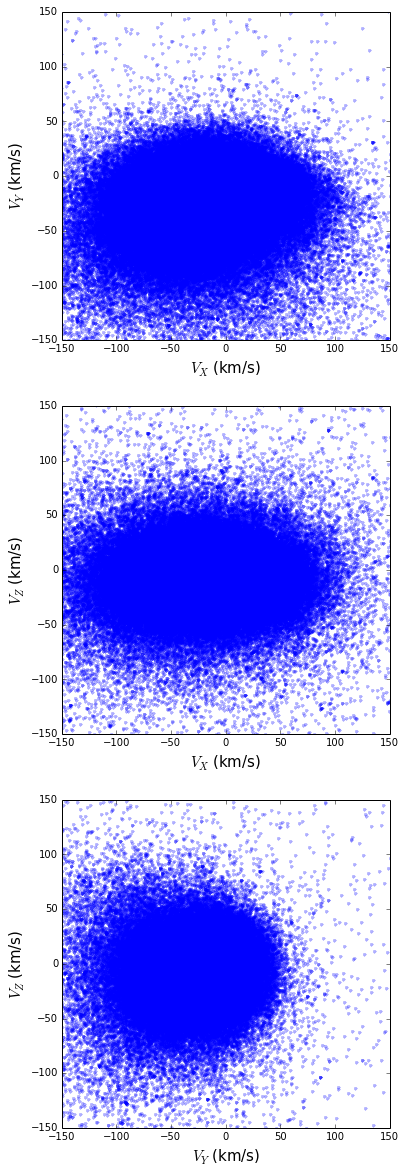

In [39]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = [20,20])

ax1.plot(U, V, 'b.', alpha = .3)
ax1.set(xlim=(-150, 150), ylim=(-150,150), xlabel = '$V_{X}$ (km/s)', ylabel = '$V_{Y}$ (km/s)')
ax1.set_aspect('equal', adjustable='box')
ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)

ax2.plot(U, W, 'b.', alpha = .3)
ax2.set(xlim=(-150, 150), ylim=(-150,150), xlabel = '$V_{X}$ (km/s)', ylabel = '$V_{Z}$ (km/s)')
ax2.set_aspect('equal', adjustable='box')
ax2.xaxis.label.set_size(15)
ax2.yaxis.label.set_size(15)

ax3.plot(V, W, 'b.', alpha = .3)
ax3.set(xlim=(-150, 150), ylim=(-150,150), xlabel = '$V_{Y}$ (km/s)', ylabel = '$V_{Z}$ (km/s)')
ax3.set_aspect('equal', adjustable='box')
ax3.xaxis.label.set_size(15)
ax3.yaxis.label.set_size(15)

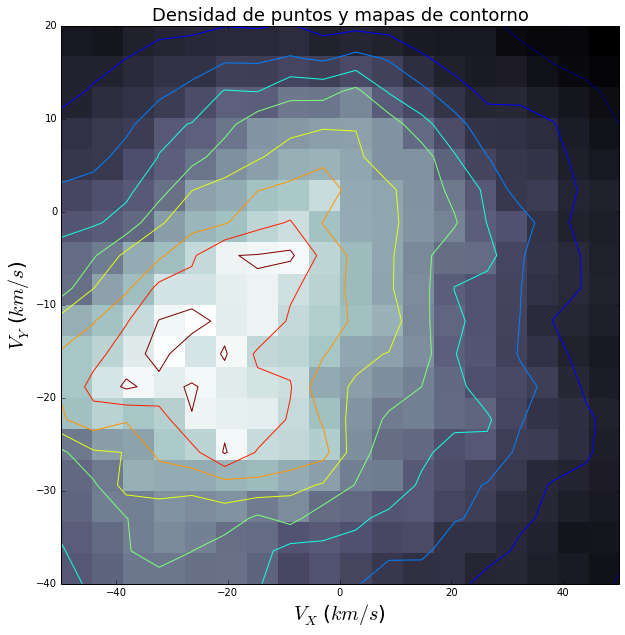

In [38]:
from matplotlib.colors import LogNorm

f, ax = plt.subplots(1,1, figsize=[10,10])
counts, xbins ,ybins ,image = ax.hist2d(U, V, bins= 18, range=[[-50, 50],[-40, 20]], cmap='bone')
ax.contour(counts.transpose(),10, extent=[-50, 50, -40, 20], linewidth = 9)
ax.set(xlabel = '$V_{X}$ ($km/s$)', ylabel = '$V_{Y}$ ($km/s$)', title = 'Densidad de puntos y mapas de contorno')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(18)